# Population Regression vs OLS Estimation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm  
import yfinance as yf

np.random.seed(10)

In [2]:
# use yfinance api to extract data. 
START = "2010-12-30"
END = "2022-05-31"

df = yf.download("SPY EEM OIL", start=START, end=END)['Adj Close']
df.dropna(inplace=True)
rets = df.pct_change().dropna()

[*********************100%***********************]  3 of 3 completed


In [3]:
df.head()

,EEM,OIL,SPY
Date,,,
2011-04-21,39.571449,50.349998,107.859985
2011-04-25,39.248127,50.049999,107.747108
2011-04-26,39.587223,50.299999,108.674294
2011-04-27,39.516251,50.810001,109.383797
2011-04-28,39.192913,50.700001,109.738541


In [4]:
rets.head()

,EEM,OIL,SPY
Date,,,
2011-04-25,-0.008171,-0.005958,-0.001047
2011-04-26,0.008640,0.004995,0.008605
2011-04-27,-0.001793,0.010139,0.006529
2011-04-28,-0.008182,-0.002165,0.003243
2011-04-29,0.006037,0.006706,0.002351


# Theoretical Model

#### Assume we have the following model for a portfolio
$$r^p_t = \alpha + \boldsymbol{x}_t'\boldsymbol{\beta} + \epsilon_t $$
#### Simulate this "true" model for a sample of size $T$

In [6]:
rets.shape

(2794, 3)

In [7]:
T = rets.shape[0]
N = rets.shape[1]

eps_vol = .01
eps = pd.DataFrame(np.random.normal(loc=0, scale =eps_vol, size=T), index=rets.index, columns=['epsilon'])

betas = {'SPY':.5, 'OIL':.25, 'EEM':.25}
X = rets[list(betas.keys())]
alpha = .001

port = pd.DataFrame(alpha + X @ list(betas.values()) + eps['epsilon'], index=rets.index, columns=['port'])

In [9]:
mult = X @ list(betas.values()) 

In [10]:
mult.shape

(2794,)

<AxesSubplot:xlabel='Date'>

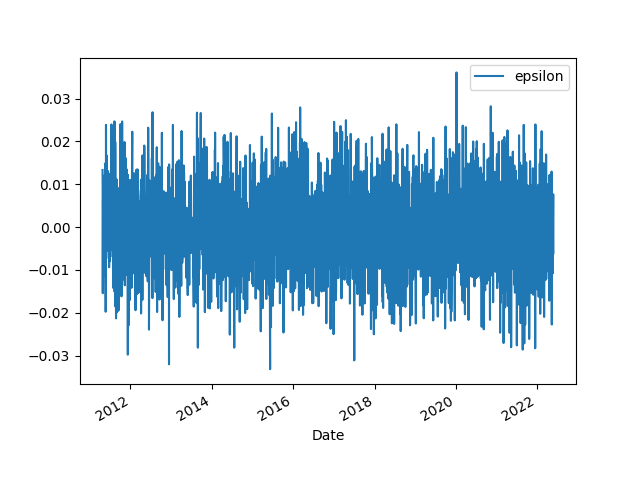

In [8]:
eps.plot()

## Estimate the Theoretical Model with OLS

$$r^p_t = a + \boldsymbol{x}_t'\boldsymbol{b} + e_t $$

In [11]:
mod = sm.OLS(port, sm.add_constant(X)).fit()
e = pd.DataFrame(mod.resid,columns=['e'])
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   port   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     1313.
Date:                Sat, 18 Jun 2022   Prob (F-statistic):               0.00
Time:                        17:43:52   Log-Likelihood:                 8974.9
No. Observations:                2794   AIC:                        -1.794e+04
Df Residuals:                    2790   BIC:                        -1.792e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      4.595      0.000       0.000       0.001
SPY            0.4394      0.028     15.570      0.000       0.384       0.495
OIL            0.2644      0.009     31.019      0.000       0.248       0.281
EEM            0.2628      0.022     11.920      0.000       0.220       0.306
==============================================================================
Omnibus:                        1.034   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.596   Jarque-Bera (JB):                1.021
Skew:                          -0.047   Prob(JB):                        0.600
Kurtosis:                       3.002   Cond. No.                         184.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
predicted = pd.DataFrame(mod.predict(sm.add_constant(X)), columns=['pred'])
concat = pd.concat([port, predicted, e], axis=1)
port.shape, predicted.shape, e.shape

((2794, 1), (2794, 1), (2794, 1))

In [31]:
concat['e_compute'] = concat['port'] - concat['pred']

In [32]:
concat.head()

,port,pred,e,e_compute
Date,,,,
2011-04-25,0.010260,-0.003333,0.013593,0.013593
2011-04-26,0.015864,0.008223,0.007641,0.007641
2011-04-27,-0.009103,0.005928,-0.015032,-0.015032
2011-04-28,-0.000049,-0.000448,0.000399,0.000399
2011-04-29,0.011575,0.005243,0.006332,0.006332


### Examine the correlations between the regressors, the target, and the fit, and the residuals

In [13]:
data = pd.concat([X,port,eps,e],axis=1)
data['port_fit'] = mod.predict(sm.add_constant(X))
data.corr().style.format('{:.2%}')

,SPY,OIL,EEM,port,epsilon,e,port_fit
SPY,100.00%,32.32%,79.65%,64.68%,-1.15%,0.00%,84.80%
OIL,32.32%,100.00%,31.61%,56.63%,1.14%,-0.00%,74.24%
EEM,79.65%,31.61%,100.00%,62.57%,0.01%,0.00%,82.02%
port,64.68%,56.63%,62.57%,100.00%,64.70%,64.66%,76.28%
epsilon,-1.15%,1.14%,0.01%,64.70%,100.00%,99.97%,0.08%
e,0.00%,-0.00%,0.00%,64.66%,99.97%,100.00%,0.00%
port_fit,84.80%,74.24%,82.02%,76.28%,0.08%,0.00%,100.00%


## Main lessons

- population residual is uncorrelated to regressors in population, but in any given sample it will have at least small, non-zero correlations.
- estimated model forces sample residuals to have zero correlations in-sample. 
- Thus, $\epsilon$ and $e$ differ at least a little. (Above >99.94% correlated.)

# Regression with Omitted Variables

### If we omit a regressor
Suppose we label one regressor as $z$, writing
$$\boldsymbol{x} = \begin{bmatrix}\boldsymbol{\check{x}}\\ z\end{bmatrix},\quad \boldsymbol{\beta} = \begin{bmatrix}\boldsymbol{\check{\beta}}\\ \beta^z\end{bmatrix}, \quad \boldsymbol{b} = \begin{bmatrix}\boldsymbol{\check{b}}\\ b^z\end{bmatrix}$$
If we omit $z$, then $\check{x}$ are the remaining regressors.

Then
$$r^p_t = \alpha + \boldsymbol{\check{x}}_t'\boldsymbol{\check{\beta}} + z_t\beta^z + \epsilon_t $$
$$= \alpha + \boldsymbol{\check{x}}_t'\boldsymbol{\check{\beta}} + \underbrace{z_t\beta^z + \epsilon_t}_{\upsilon_t}$$
$$= \alpha + \boldsymbol{\check{x}}_t'\boldsymbol{\check{\beta}} + \upsilon_t$$
where $\upsilon_t$ is the population error with $z$ omitted. Note that even though $\epsilon_t$ is uncorrelated with $x$, then $\upsilon_t$ is certainly correlated with $x$, even in the population.

If we go ahead and estimate $r^p$ omitting the regressor, OLS will return: $\boldsymbol{\ddot{b}}$, which are the biased OLS estimates of $\check{\beta}$. Note that this will not be the same as the subset of OLS estimates from the full model, $\check{b}$.

Thus,
$$r^p_t = \ddot{a} + \boldsymbol{\check{x}}_t'\boldsymbol{\ddot{b}} + \ddot{e}_t$$
By construction OLS ensures $\ddot{e}$ is uncorrelated with $\check{x}$ even though $\upsilon_t$ is correlated to $\check{x}$.

## Investigate empirically
- Omit one of the true population variables.
- Re-estimate the regression, omitting the regressor.
- How do the estimates change?
- How do the sample residuals change?

In [14]:
list_omit = ['EEM']
Xomit = X.drop(columns=list_omit)
mod_omit = sm.OLS(port, sm.add_constant(Xomit)).fit()
e_omit = pd.DataFrame(mod_omit.resid,columns=['e omit'])
mod_omit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   port   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     1783.
Date:                Sat, 11 Jun 2022   Prob (F-statistic):               0.00
Time:                        00:24:18   Log-Likelihood:                 8845.8
No. Observations:                2794   AIC:                        -1.769e+04
Df Residuals:                    2791   BIC:                        -1.767e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      2.515      0.012       0.000       0.001
SPY            0.7320      0.019     39.072      0.000       0.695       0.769
OIL            0.2672      0.009     30.099      0.000       0.250       0.285
==============================================================================
Omnibus:                        1.457   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.483   Jarque-Bera (JB):                1.505
Skew:                          -0.051   Prob(JB):                        0.471
Kurtosis:                       2.952   Cond. No.                         98.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Differences between $\boldsymbol{\check{b}}$ and $\boldsymbol{\ddot{b}}$

Note that omitting the regressor substantially changes the OLS estimates of the remaining regressors to $\ddot{b}$. These are biased estimates of the full model betas, $\check{\beta}$, and thus they will not be close to $\check{b}$.

### Examine the correlation between the omitted model's residual with the included regressors. 
$\text{corr}(\dot{x},\upsilon)\ne 0$
and this is the source of the bias.

In [15]:
data['epsilon_omit'] = eps + X[list_omit].values * betas[list_omit[0]]
data['e_omit'] = e_omit
data['port_fit_omit'] = mod_omit.predict(sm.add_constant(Xomit))

data.corr().style.format('{:.2%}')

,SPY,OIL,EEM,port,epsilon,e,port_fit,epsilon_omit,e_omit,port_fit_omit
SPY,100.00%,32.32%,79.65%,64.68%,-1.15%,0.00%,84.80%,25.17%,-0.00%,86.37%
OIL,32.32%,100.00%,31.61%,56.63%,1.14%,-0.00%,74.24%,11.50%,0.00%,75.62%
EEM,79.65%,31.61%,100.00%,62.57%,0.01%,0.00%,82.02%,32.98%,13.14%,71.92%
port,64.68%,56.63%,62.57%,100.00%,64.70%,64.66%,76.28%,81.71%,66.26%,74.89%
epsilon,-1.15%,1.14%,0.01%,64.70%,100.00%,99.97%,0.08%,94.41%,97.86%,-0.19%
e,0.00%,-0.00%,0.00%,64.66%,99.97%,100.00%,0.00%,94.38%,97.58%,0.00%
port_fit,84.80%,74.24%,82.02%,76.28%,0.08%,0.00%,100.00%,27.11%,4.15%,98.18%
epsilon_omit,25.17%,11.50%,32.98%,81.71%,94.41%,94.38%,27.11%,100.00%,96.71%,23.53%
e_omit,-0.00%,0.00%,13.14%,66.26%,97.86%,97.58%,4.15%,96.71%,100.00%,-0.00%
port_fit_omit,86.37%,75.62%,71.92%,74.89%,-0.19%,0.00%,98.18%,23.53%,-0.00%,100.00%


## Empirical observations

- Given that the remaining regressors, $\dot{x}$, are highly correlated with the omitted variable, $z$, the regression's fit (R-squared), is nearly as high. 
- The beta of the omitted variable, $\beta^z$, is mostly absorbed by the OLS estimate of $\dot{\beta}$, denoted $\dot{b}$.

### The residuals
- new sample residual will force 0 correlation to remaining regressors, but NOT to omitted.
- population model omitting will then have substantial corr between X and upsilon
- sample fit omitting will have no corr between X and u but will have corr between X and e

# Check for Bias

The formula tells us that the OLS estimator will have a bias relative to the actual beta equal to:
$$bias = (X'X)^{-1}X'\epsilon$$
This bias is simply the regression of the true epsilon on the regressors.

### In real applications, we will *never* know the true epsilon, so we can't check this. But here, we have started with a known (simulated) model, so we can investigate the epsilon.

### Bias for the omitted variable case:

In [16]:
mod_epsomit = sm.OLS(data['epsilon_omit'],Xomit).fit()
mod_epsomit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           epsilon_omit   R-squared (uncentered):                   0.064
Model:                            OLS   Adj. R-squared (uncentered):              0.063
Method:                 Least Squares   F-statistic:                              94.67
Date:                Sat, 11 Jun 2022   Prob (F-statistic):                    1.66e-40
Time:                        00:24:47   Log-Likelihood:                          8842.3
No. Observations:                2794   AIC:                                 -1.768e+04
Df Residuals:                    2792   BIC:                                 -1.767e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
SPY            0.2295      0.019     12.254      0.000       0.193       0.266
OIL            0.0175      0.009      1.964      0.050    2.87e-05       0.035
==============================================================================
Omnibus:                        1.458   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.482   Jarque-Bera (JB):                1.507
Skew:                          -0.051   Prob(JB):                        0.471
Kurtosis:                       2.951   Cond. No.                         2.29
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## The bias is seen in the estimated coefficients.

Sure enough, we see large t-stats (this bias is real, not just noise,) and it almost perfectly explains the difference between $\ddot{b}$ and $\check{\beta}$.


### Let's double check that there was not bias in the full model.

In [17]:
mod_eps = sm.OLS(data['epsilon'],Xomit).fit()
mod_eps.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                epsilon   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):             -0.000
Method:                 Least Squares   F-statistic:                             0.6288
Date:                Sat, 11 Jun 2022   Prob (F-statistic):                       0.533
Time:                        00:24:52   Log-Likelihood:                          8911.5
No. Observations:                2794   AIC:                                 -1.782e+04
Df Residuals:                    2792   BIC:                                 -1.781e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
SPY           -0.0175      0.018     -0.955      0.340      -0.053       0.018
OIL            0.0075      0.009      0.865      0.387      -0.010       0.024
==============================================================================
Omnibus:                        1.700   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.427   Jarque-Bera (JB):                1.747
Skew:                          -0.047   Prob(JB):                        0.418
Kurtosis:                       2.921   Cond. No.                         2.29
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### As expected, we see no signs of bias.

The OLS estimates here are not exactly zero due to sample noise, but neither are close to being statistically significant, and both show 0 as well within the confidence interval.

# Do we **care** about omitted variable bias?

- Above, we have a *true* model where the portfolio depends on SPY, OIL, and EEM.

- But the omitted model on just SPY and OIL gets almost as high of an R-squared.

In what situations would it matter to know that EEM is part of the linear model?

- This matters for predicting there will be exogenous changes in one regressor. Then the causation matters.
- This doesn't matter when the regressors will move randomly, and having a highly correlated proxy delivers most of the same statistical information.

In finance, we are usually in the second case--it doesn't matter.

In applied economics, public policy, etc. they are often in the first situation--they want to be able to attribute a causal effect so that if some intervention forces a change in $x$ they can be confident it will impact as expected.

Imagine that we somehow **force** a change in SPY. Would we expect the portfolio to increase by 0.75 as indicated by the omitted variable regression? No. We would expect it to increase by 0.5, the true effect. The usual channel of SPY impacting EEM is broken due to the exogenous change in SPY.

But this is unrealistic--we will never have an exogenous change in SPY. Rather, we will observe changes in SPY, in which case we will still have the correlated impact via EEM. Thus, if we know SPY changes and no nothing about EEM, we would expect a change of 0.75 in the portfolio. If we know SPY goes up 1 and we **also** know EEM does not change, then we would expect a change of 0.50 in the portfolio.

### As quants, we will rarelly care about the causal impact, so omitted variable regressions will be fine, since for random variation they are optimal predictions.

# Omitted Variable Bias may be better than Multicolinearity

## Suppose we have a theoretical model that now depends on a few extra regressors:

In [18]:
# use yfinance api to extract data. 

df = yf.download("SPY EEM OIL HYG IXUS EFA QQQ VTV IVV VOO", start=START, end=END)['Adj Close']
df.dropna(inplace=True)

rets = df.pct_change().dropna()

[*********************100%***********************]  10 of 10 completed


In [19]:
T = rets.shape[0]
N = rets.shape[1]

eps_vol = .02
eps = pd.DataFrame(np.random.normal(loc=0, scale =eps_vol, size=T), index=rets.index, columns=['epsilon'])

betas = {'SPY':.2, 'OIL':.2, 'EEM':.1, 'HYG':.1, 'EFA':.1, 'IXUS':.1, 'QQQ':.1, 'VTV':.1}
X = rets[list(betas.keys())]
alpha = .001

port_multi = pd.DataFrame(alpha + X @ list(betas.values()) + eps['epsilon'], index=rets.index, columns=['port'])

In [20]:
mod = sm.OLS(port_multi, sm.add_constant(X)).fit()
e = pd.DataFrame(mod.resid,columns=['e'])
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   port   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     83.90
Date:                Sat, 11 Jun 2022   Prob (F-statistic):          8.80e-123
Time:                        00:26:20   Log-Likelihood:                 6006.8
No. Observations:                2413   AIC:                        -1.200e+04
Df Residuals:                    2404   BIC:                        -1.194e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.000      3.531      0.000       0.001       0.002
SPY           -0.2305      0.365     -0.631      0.528      -0.947       0.486
OIL            0.1910      0.019     10.041      0.000       0.154       0.228
EEM            0.1702      0.085      2.013      0.044       0.004       0.336
HYG            0.1870      0.131      1.427      0.154      -0.070       0.444
EFA            0.3827      0.199      1.923      0.055      -0.007       0.773
IXUS          -0.2920      0.256     -1.141      0.254      -0.794       0.210
QQQ            0.2158      0.149      1.446      0.148      -0.077       0.508
VTV            0.4590      0.221      2.077      0.038       0.026       0.892
==============================================================================
Omnibus:                        0.242   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.886   Jarque-Bera (JB):                0.264
Skew:                           0.024   Prob(JB):                        0.876
Kurtosis:                       2.980   Cond. No.                     1.08e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.08e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [21]:
list_omit = ['HYG','EEM','EFA','IXUS','QQQ','VTV']
Xomit = X.drop(columns=list_omit)
mod_omit = sm.OLS(port_multi, sm.add_constant(Xomit)).fit()
e_omit = pd.DataFrame(mod_omit.resid,columns=['e omit'])
mod_omit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   port   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     319.3
Date:                Sat, 11 Jun 2022   Prob (F-statistic):          9.40e-124
Time:                        00:26:43   Log-Likelihood:                 5993.4
No. Observations:                2413   AIC:                        -1.198e+04
Df Residuals:                    2410   BIC:                        -1.196e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.000      3.370      0.001       0.001       0.002
SPY            0.7409      0.041     18.073      0.000       0.661       0.821
OIL            0.2028      0.018     10.977      0.000       0.167       0.239
==============================================================================
Omnibus:                        0.172   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.918   Jarque-Bera (JB):                0.175
Skew:                           0.021   Prob(JB):                        0.916
Kurtosis:                       2.994   Cond. No.                         101.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
display(f'Condition Number for FULL: {mod.condition_number:.1f}')
display(f'Condition Number for Omitted: {mod_omit.condition_number:.1f}')

'Condition Number for FULL: 1084.0'

'Condition Number for Omitted: 100.9'

## Another Example

Suppose we have a portfolio of SPY , IVV, and VOO.

Is it helpful to correctly specify the model, or to omit IVV and VOO?

In [27]:
T = rets.shape[0]
N = rets.shape[1]

eps_vol = .02
eps = pd.DataFrame(np.random.normal(loc=0, scale =eps_vol, size=T), index=rets.index, columns=['epsilon'])

betas = {'SPY':.4, 'IVV':.3, 'VOO':.3}
X = rets[list(betas.keys())]
alpha = .001

port_multi = pd.DataFrame(alpha + X @ list(betas.values()) + eps['epsilon'], index=rets.index, columns=['port'])

In [28]:
mod = sm.OLS(port_multi, sm.add_constant(X)).fit()
e = pd.DataFrame(mod.resid,columns=['e'])
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   port   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     251.4
Date:                Sat, 11 Jun 2022   Prob (F-statistic):          6.26e-142
Time:                        00:29:08   Log-Likelihood:                 6073.4
No. Observations:                2413   AIC:                        -1.214e+04
Df Residuals:                    2409   BIC:                        -1.212e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.000      5.357      0.000       0.001       0.003
SPY            0.3934      0.873      0.451      0.652      -1.319       2.105
IVV            2.1223      1.013      2.096      0.036       0.137       4.108
VOO           -1.4976      0.943     -1.588      0.112      -3.347       0.352
==============================================================================
Omnibus:                        4.895   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.087   Jarque-Bera (JB):                4.931
Skew:                          -0.084   Prob(JB):                       0.0850
Kurtosis:                       3.144   Cond. No.                     3.16e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [29]:
list_omit = ['IVV','VOO']
Xomit = X.drop(columns=list_omit)
mod_omit = sm.OLS(port_multi, sm.add_constant(Xomit)).fit()
e_omit = pd.DataFrame(mod_omit.resid,columns=['e omit'])
mod_omit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   port   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     748.9
Date:                Sat, 11 Jun 2022   Prob (F-statistic):          8.02e-144
Time:                        00:29:34   Log-Likelihood:                 6071.1
No. Observations:                2413   AIC:                        -1.214e+04
Df Residuals:                    2411   BIC:                        -1.213e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.000      5.341      0.000       0.001       0.003
SPY            1.0293      0.038     27.366      0.000       0.956       1.103
==============================================================================
Omnibus:                        5.171   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.075   Jarque-Bera (JB):                5.215
Skew:                          -0.087   Prob(JB):                       0.0737
Kurtosis:                       3.146   Cond. No.                         94.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
display(f'Condition Number for FULL: {mod.condition_number:.1f}')
display(f'Condition Number for Omitted: {mod_omit.condition_number:.1f}')

'Condition Number for FULL: 3155.6'

'Condition Number for Omitted: 94.5'

### Scratch

In [31]:
eps_omit = eps['epsilon'].values
for i in list_omit:
    eps_omit += X[i].values * betas[i]
eps_omit = pd.DataFrame(eps_omit,index=eps.index,columns=['epsilon_omit'])

In [36]:
temp = pd.concat([X,port_multi,eps,e,eps_omit,e_omit],axis=1).corr().style.format('{:.1%}')